In [1]:
# Necessary packages
using SparseArrays; # for sparse matrix and vecotr handling 
using LinearAlgebra; # used for rank computations 
using Base.Threads; # parallel computing
using Modulo2; # computing over Z2
using Mods; #computing over finite fields
using BenchmarkTools; # for benchmarking and estimate time functions
using Random; # for random matrix generation
using Primes; # determining which field to compute over
using ProgressMeter; # for displaying progress bar

In [2]:
# structures for graphs 

# Define Graph Structure
mutable struct graph
    # araray of vertex labels
    vertices::Array 

    # array of edges in the graph. Needs to be simple graph so it should be symmetric and reflexive 
    edges::Array 
end   

In [3]:
function convert_to_coords(maps,nonDeg)
    coords=[]
    for m in maps 
        v = zeros(ZZ2,length(nonDeg))
        for x in m 
            i = findfirst(y->y==x,nonDeg)
            if !(i==nothing)
                v[i]+=ZZ2(1)
            end
        end
        push!(coords,v)
    end
    return coords 
end

function get_nhood_dict(G)
    # initialize nhood dict for checking maps
    nhoodDict = Dict{Any,Array{Any}}()
    for v in G.vertices
        nhoodDict[v] = []
    end

    for e in G.edges
        push!(nhoodDict[e[1]], e[2])
    end
    return nhoodDict
end

function remove_vertex(v,G,nhoodDict)

    # remove from graph
    filter!(x -> x != v, G.vertices)
    filter!(t -> v ∉ t, G.edges)    

    pop!(nhoodDict,v)

    for key in keys(nhoodDict)
        filter!(x -> x != v, nhoodDict[key])
    end

    return G, nhoodDict
end

function remove_vert_deg_n_per(G,nhoodDict)

    for key in keys(nhoodDict) 
        for v in filter(x -> x != key, nhoodDict[key]) # dont consider loops

            # check if v is connected to everything the key is
            conn = true
            for w in filter(x -> x != key, nhoodDict[key]) # still dont consider loops bc already know key ~ v
                if !(w in nhoodDict[v])
                    conn = false
                    break
                end
            end

            if conn == true
                G, nhooodDict = remove_vertex(key,G,nhoodDict)
                return G, nhoodDict, key, v, true
            end
        end
    end

    return G, nhoodDict, nothing, nothing, false # no case found
end

function preprocess_graph_per(G::graph)
    ch_vert = Dict{}()

    G2 = graph(deepcopy(G.vertices), deepcopy(G.edges))
    nhoodDict = get_nhood_dict(G2)
    flg = true

    while flg
        G2, nhoodDict, v, w, flg = remove_vert_deg_n_per(G2,nhoodDict)
        ch_vert[v] = w # v was replaced with w
    end

    return G2, ch_vert
end

function complete_to_basis(A,B) # adds elements from B to complete to a basis
    if length(A) == 0 
        return B
    end
    basis = deepcopy(A)
    matA = ZZ2Matrix(hcat(A ...))
    r = rank(matA)
    for b in B
        
        M = hcat(matA,deepcopy(b))
        
        r2 = rank(M)

        if r2 > r # not in span 
            push!(basis,deepcopy(b))
            matA=M
            r=r2
        end
    end

    return basis
end

function determine_generators(image,kernel) # determine generators of quotient 
    if image == []
        return kernel
    end
    generators = []

    cMat = ZZ2Matrix(hcat(image ...))
    r = rank(cMat)
    
    for v in kernel 
        M = hcat(cMat,copy(v))
        r2 = rank(M)
        
        if r2 > r # kernel elet not in span 
            push!(generators,v)
            cMat = M
            r = r2 
        end
    end
    return generators 
end

function get_vec(map, cdict, len)
    v = zeros(ZZ2,len)
    faces = [[map[1],map[2]],[map[3],map[4]],[map[2],map[4]],[map[1],map[3]]]

    for i = 1:4
        try
            c = cdict[faces[i]]
            v[c] += 1
        catch e 
        end
    end

    return v
end

# Functions for persistence
function image_basis(A::ZZ2Matrix) 
    r,M = rref(A,reduced=true)
    m,n = size(M)
    pivot_cols = Channel{}(n)

    # determine the pivot cols
    @threads for i=1:m
        for j=1:n 
            if M[i,j] == 1 #pivot found 
                put!(pivot_cols,j)
                break 
            end
        end
    end

    close(pivot_cols)
    pivot_cols = collect(pivot_cols)

    return [collect(A[:,j]) for j in pivot_cols]
end

function nullspace_basis(A::ZZ2Matrix) # nullspace of matrix 
    r,A = rref(A,reduced=true)
    m,n = size(A)
    pivot_cols = []

    # determine the pivot cols
    for i=1:m
        for j=1:n 
            if A[i,j] == 1 #pivot found 
                push!(pivot_cols,j)
                break 
            end
        end
    end

    cols = collect(1:n) # all col inds 
    free_cols = setdiff(cols,pivot_cols) # cols that arent pivots are free 
    
    if length(free_cols) == 0 # nullspace zero
        return []
    end

    basis = []

    for i in free_cols 
        # build nullspace elet
        v = zeros(ZZ2,n)
        v[i] = ZZ2(1)
        # determine pivot entries
        for (row_i, pcol) in enumerate(pivot_cols)
            
            c_sum = ZZ2(0)
            for col in 1:n
                if col != pcol
                    c_sum += A[row_i, col]*v[col]
                end
            end
            
            v[pcol] = c_sum
        end
        push!(basis,v)
    end

    return basis 
end

function convert_to_coords(maps,nonDeg)
    coords=[]
    for m in maps 
        v = zeros(ZZ2,length(nonDeg))
        for x in m 
            i = findfirst(y->y==x,nonDeg)
            if !(i==nothing)
                v[i]+=ZZ2(1)
            end
        end
        push!(coords,v)
    end
    return coords 
end


function computeNextGens(G,c_gens) # compute the next set of generators given the current one
    # initialize nhood dict for checking maps
    nhoodDict = get_nhood_dict(G)

    C0 = G.vertices
    C1 = [[e[1], e[2]] for e in G.edges if e[1] != e[2]]
    C1 = unique!(C1)

    # n-th boundary map 
    img = []
    len = length(G.vertices)

    for c in C1 
        v = zeros(ZZ2,len)
        v[findfirst(x->x == c[1], C0)] += 1
        v[findfirst(x->x == c[2], C0)] += 1
        push!(img,v)
    end
  
    if length(img)==0
        delN = []
    else
        delN=hcat(img ...)
    end
    
    
    # determine the 2 boundary matrix
    B = Channel{}(length(G.edges)*length(G.edges)) # channel of coordinate vectors

    cdict = Dict{}()
    
    for i = 1:length(C1)
        cdict[C1[i]] = i
    end

    len = length(C1)

    @threads for i = 1:length(G.vertices)
        v = G.vertices[i]
        nv = nhoodDict[v]

        geq_v = G.vertices[i+1:end]
        
        #Handling for all distinct vertices
        for w in intersect(nv, geq_v)
            nw = nhoodDict[w]
            j = findfirst(x -> x == w, G.vertices)
            geq_w = G.vertices[j+1:end]
            for v2 in intersect(nv, geq_w)
                nv2 = nhoodDict[v2] 
                for w2 in intersect(nw, nv2, geq_v)
                    
                    vec = get_vec([v,w,v2,w2],cdict,len)
                    put!(B,vec)
                    vec = get_vec([v,v2,w,w2],cdict,len)
                    put!(B,vec)
    
                    
                end
                
                # if w2 = v 
                vec = get_vec([v,w,v2,v],cdict,len)
                put!(B,vec)

                vec = get_vec([v,v2,w,v],cdict,len)
                put!(B,vec)

            end

            # if v2 = v 
            for w2 in intersect(nw, nv, geq_w)

                vec = get_vec([v,w,v,w2],cdict,len)
                put!(B,vec)

                vec = get_vec([v,v,w,w2],cdict,len)
                put!(B,vec)
    

            end
            
            for w2 in filter!(x -> x != w, intersect(nw, geq_v)) 
                vec = get_vec([w,w2,v,w],cdict,len)
                put!(B,vec)
                vec = get_vec([w,v,w2,w],cdict,len)
                put!(B,vec)
            end

            vec = get_vec([v,v,w,v],cdict,len)
            put!(B,vec)

            vec = get_vec([w,w,v,w],cdict,len)
            put!(B,vec)

        end


    end
    
    close(B)
    img = collect(B)
  
    delN1=hcat(img ...)

    

    if delN1 == []
        img = []
    else
        img = image_basis(delN1)
    end
    if delN == []
        ker = []
    else
        ker = nullspace_basis(delN)
    end



    c_gens = convert_to_coords(c_gens,C1)

    # may have created lin dependancies 
    if !(length(c_gens) == 0)
        M = ZZ2Matrix(hcat(c_gens ...))
        c_gens = image_basis(M)
    end

    ker = complete_to_basis(c_gens,ker) # keep the current generators

    
    gens = determine_generators(img,ker)
    
    gens_edge = []

    for g in gens 
        c_gen = Set()
        for (i,a) in enumerate(g)
            if a == 1 
                push!(c_gen,C1[i])
            end
        end

        push!(gens_edge,c_gen)
    end


    # H1 generators
    return gens_edge
end

function convert_generator(gen, conv)
    gen2=[]

    for g in gen
        e1=g[1]
        while e1 in keys(conv)
            e1=conv[e1]
        end

        e2=g[2]
        while e2 in keys(conv)
            e2=conv[e2]
        end

        if !(e1==e2)
            push!(gen2,[e1,e2])
        end

    end

    gen3=Set()

    # everything appears at most once
    for g in gen2
        if !(g in gen3)
            n=count(==(g),gen2)
            if n%2 != 0
                push!(gen3,g)
            end
        end
    end

    return gen3
end

#n_iter=0 does complete filtration, can break into, say 50, intervals with n_iter=50
function persistenceHomology(F, n_iter=0) # persistence homology of filtration of graphs, should be dict of (x,y)-->d(x,y)
    edge_weights = sort(unique!(collect(values(F)))) # weights of all edges 
    generators = Dict{}() # to store generators and lengths

    k = collect(keys(F))
    V = []
    for e in k 
        push!(V,e[1])
    end
    V = unique!(V)

    c_gens=[]
    
    max_weight = maximum(edge_weights)

    if n_iter==0
        n_iter=length(edge_weights)
    end

    
    for r=0:(max_weight/n_iter):max_weight 
        
        E = []
        for e in k 
            if F[e]<=r
                push!(E,e)
            end
        end
        G = graph(V,E)
        
        G, conv = preprocess_graph_per(G) 
        
        conv_back = Dict{}() # dict to convert gens back
        c_gens2 = []
        # convert generators 
        for g in c_gens # generators
            conv_g = convert_generator(g,conv)

            conv_back[conv_g] = g 
            push!(c_gens2, conv_g)
        end

        n_gens = computeNextGens(G,c_gens2)

        # convert back 

        n_gens2 = []

        #check if current gens remain generators
        for g in c_gens 
            conv_g = convert_generator(g,conv)

            #check if remains generator
            if conv_g in n_gens 
                push!(n_gens2, g)
                n_gens = filter(x -> x != conv_g, n_gens) # remove to avoid repeats
            end
        end

        n_gens2=vcat(n_gens2,n_gens) # add ones that remain


        n_gens = deepcopy(n_gens2)

        
        #add birth/death info 
        for g in c_gens
            if !(g in n_gens)
                push!(generators[g],r) # death 
            end
        end

        for g in n_gens 
            if !(g in c_gens)
                generators[g] = [r] # birth 
            end
        end
        c_gens = deepcopy(n_gens)
    end

    # all c gens killed in next step 
    for g in c_gens 
        push!(generators[g],edge_weights[end])
    end

    return generators 
end

persistenceHomology (generic function with 2 methods)

In [4]:
F = Dict{}()

for i=0:5
    for j=0:5

        if (i+1)%6==j || (j+1)%6==i
            F[(i,j)] = 0.5 
        
        elseif (i,j) == (0,4) || (i,j) == (4,0)
            F[(i,j)] = 1 
        elseif i==j 
            F[(i,j)] = 0
        else 
            F[(i,j)] = 2
        end
    end
end

persistenceHomology(F)

Dict{Any, Any} with 1 entry:
  Set(Any[[0, 5], [1, 0], [1, 2], [3, 4], [4, 5], [3, 2]]) => [0.5, 2.0]

In [1]:
# normal TDA homology: 

using Ripserer                                  

function pers_h1(dist_dict, modulus::Int = 2) 
    
    vset  = Set{Any}()
    for (u,v) in keys(dist_dict)
        push!(vset,u); push!(vset,v)
    end
    verts = collect(vset)                       
    vidx  = Dict(v => i for (i,v) in enumerate(verts))
    n = length(verts)
    D = fill(Inf, n, n)
    for i in 1:n
        D[i,i] = 0.0
    end
    for ((u,v), d) in dist_dict
        i, j = vidx[u], vidx[v]
        D[i,j] = D[j,i] = float(d)
    end


    h1 = ripserer(D; dim_max = 1, reps = true, modulus = modulus)[2]

    gens = NamedTuple[]
    for bar in h1
        isfinite(bar.death) || continue                 

        creator = nothing
        for (simp, coeff) in bar.representative
            coeff == 0 && continue
            length(simp) == 2 || continue
            (i, j) = collect(simp)                     
            if isapprox(D[i,j], bar.birth; atol=1e-12)
                creator = (i, j)
                break
            end
        end
        creator === nothing && continue               
        ci, cj = creator

        prev    = fill(0, n)
        visited = falses(n)
        queue   = [ci];  visited[ci] = true
        while !isempty(queue) && !visited[cj]
            v = popfirst!(queue)
            for w in 1:n
                if !visited[w] && D[v,w] < bar.birth
                    visited[w] = true
                    prev[w] = v
                    push!(queue, w)
                end
            end
        end

        path_edges = Tuple{Int,Int}[]
        if visited[cj]                              
            v = cj
            while v != ci
                push!(path_edges, (v, prev[v]))
                v = prev[v]
            end
        end

        edge_set = Set{Tuple{Int,Int}}()
        norm(u,v) = u < v ? (u,v) : (v,u)
        push!(edge_set, norm(ci,cj))
        for (u,v) in path_edges
            push!(edge_set, norm(u,v))
        end
        cycle_edges = [(verts[u], verts[v]) for (u,v) in edge_set]

        push!(gens, (birth = bar.birth,
                     death = bar.death,
                     cycle = cycle_edges))
    end
    return gens
end


pers_h1 (generic function with 2 methods)

In [6]:
using Distributions

In [7]:
d=Normal(0,1)
x=rand(d)

0.6780443908263293

In [ ]:
function generate_noisy_circle(n, stdev)
    angles = range(0, 2π, length=n+1)[1:end-1]  
    d = Normal(0,stdev)

    xs=[]
    ys=[]

    for z in angles 
        push!(xs, 2*cos(z) + rand(d))
        push!(ys, 2*sin(z) + rand(d))
    end

    return [(round(xs[i], digits=5), round(ys[i], digits=5)) for i in 1:n]
end

generate_noisy_circle (generic function with 1 method)

In [8]:
using Random, Plots

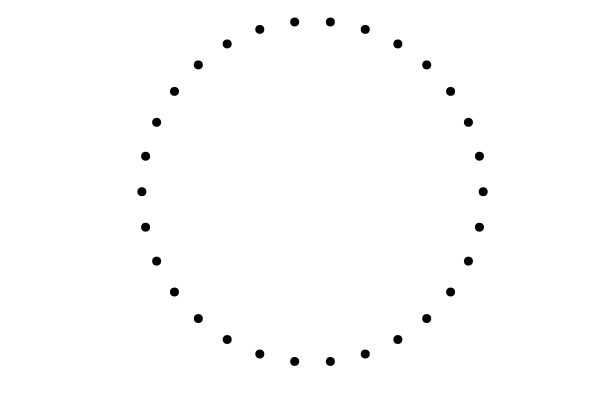

In [ ]:

circ_pts = generate_noisy_circle(30, 0.0)

# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)

In [ ]:
using PersistenceDiagrams 
function bottleneck_distance(barcode1::AbstractVector,
                              barcode2::AbstractVector)
    
    to_interval(x) = x isa PersistenceInterval ?
                     x :
                     PersistenceInterval(float(x[1]), float(x[2]))

    dgm1 = PersistenceDiagram(to_interval.(barcode1))
    dgm2 = PersistenceDiagram(to_interval.(barcode2))

    return Bottleneck()(dgm1, dgm2)   
end

bottleneck_distance (generic function with 1 method)

In [9]:
function pt_dist(p1,p2)
    return sqrt((p1[1]-p2[1])^2 + (p1[2]-p2[2])^2)
end

pt_dist (generic function with 1 method)

In [103]:
F = Dict{}()

for i=1:length(circ_pts)
    for j=1:length(circ_pts)
        F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
    end
end

x=pers_h1(F)
y=persistenceHomology(F)

perf_circ = []
for g in x 
    push!(perf_circ,(g.birth,g.death))
end
cubical_perf_circ = []
for g in values(y)
    push!(cubical_perf_circ,(g[1],g[2]))
end

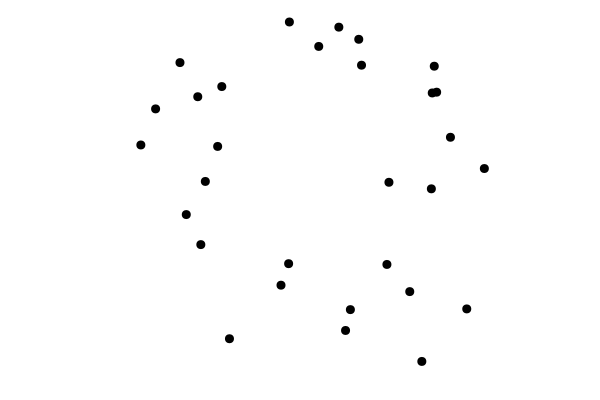

In [100]:
circ_pts = generate_noisy_circle(30, 0.4)
F = Dict{}()

for i=1:length(circ_pts)
    for j=1:length(circ_pts)
        F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
    end
end

x=pers_h1(F)
y=persistenceHomology(F)

normal = []
for g in x 
    push!(normal,(g.birth,g.death))
end
cubical = []
for g in values(y)
    push!(cubical,(g[1],g[2]))
end

# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)

In [36]:
x

3-element Vector{NamedTuple}:
 (birth = 1.935050682643739, death = 1.9375102619857267, cycle = [(20, 21), (16, 17), (16, 21), (20, 17)])
 (birth = 0.7109338406631097, death = 0.7276096891191046, cycle = [(20, 19), (20, 21), (23, 19), (23, 21)])
 (birth = 1.6299173187925822, death = 2.7046727235656443, cycle = [(23, 18), (8, 3), (28, 1), (17, 18), (17, 14), (28, 23), (8, 11), (11, 14), (1, 3)])

In [37]:
y

Dict{Any, Any} with 1 entry:
  Set(Any[[11, 14], [11, 8], [1, 27], [17, 18], [3, 1], [… => [1.63862, 2.56798]

In [30]:
V=[]
E=[]

for key in keys(F)
    if F[key] <=0.937
        push!(E,key)
        push!(V,key[1])
    end
end

V=unique!(V)
G2=graph(V,E)

graph(Any[27, 23, 17, 3, 6, 12, 9, 24, 28, 20  …  11, 4, 26, 10, 14, 5, 25, 30, 29, 7], Any[(27, 26), (23, 21), (17, 18), (3, 1), (6, 8), (12, 13), (9, 12), (24, 23), (6, 7), (28, 27)  …  (13, 11), (9, 10), (29, 1), (23, 23), (20, 21), (11, 13), (4, 1), (28, 26), (18, 17), (21, 21)])

In [38]:
length(computeNextGens(G2,[]))

1

In [108]:
c=[]
n=[]
for i=1:1000
    circ_pts = generate_noisy_circle(30, 0.5)
    F = Dict{}()

    for i=1:length(circ_pts)
        for j=1:length(circ_pts)
            F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
        end
    end

    x=pers_h1(F)
    y=persistenceHomology(F)

    normal = []
    for g in x 
        push!(normal,(g.birth,g.death))
    end
    cubical = []
    for g in values(y)
        push!(cubical,(g[1],g[2]))
    end

    push!(c,bottleneck_distance(cubical, cubical_perf_circ))
    push!(n,bottleneck_distance(normal,perf_circ))
end

In [109]:
println(mean(c))
println(mean(n))

1.0015629685087246
1.108030300144738


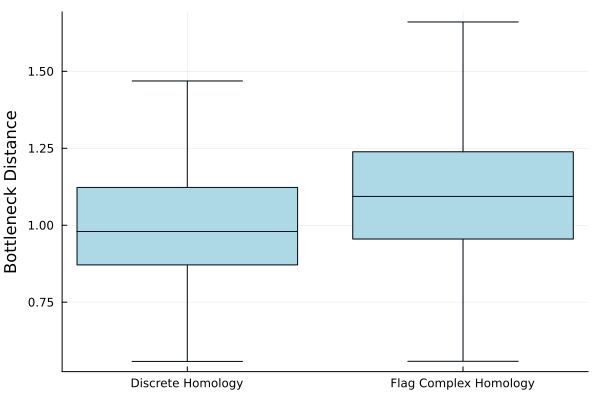

In [ ]:
using StatsPlots
using DataFrames


# Combine data and labels
grouped_data = [c; n]
labels = vcat(fill("Discrete Homology", length(c)), fill("Flag Complex Homology", length(n)))

# Create a DataFrame
df = DataFrame(value = grouped_data, group = labels)


@df df boxplot(
    :group,
    :value,
    legend = false,
    ylabel = "Bottleneck Distance",
    outliers = false,
    fillcolor = :lightblue
)


In [111]:
t = 0
for i=1:length(n)
    if c[i]<n[i]
        t+=1
    end
end

t

943

In [143]:
println(cubical)
println(normal)
println(bottleneck_distance(cubical, cubical_perf_circ))
println(bottleneck_distance(normal,perf_circ))

Any[(1.0787549447422125, 1.1044395862836935), (1.3484436809277653, 2.632675758001828)]
Any[(1.0681570903663935, 1.1287701035197557), (1.3455101219983445, 2.6453169020932066)]
0.9186907573286207
0.9273901219983445


In [144]:
println(wasserstein_distance(cubical,cubical_perf_circ))
println(wasserstein_distance(normal,perf_circ))

0.9190497311963858
0.9293688050196401


In [79]:
normal

1-element Vector{Any}:
 (1.189165082442299, 3.2784785947448243)

In [80]:
cubical

1-element Vector{Any}:
 (1.2108904620495125, 2.9061371089188297)

In [54]:
perf_circ

1-element Vector{Any}:
 (0.47076020753670356, 5.346038392754021)

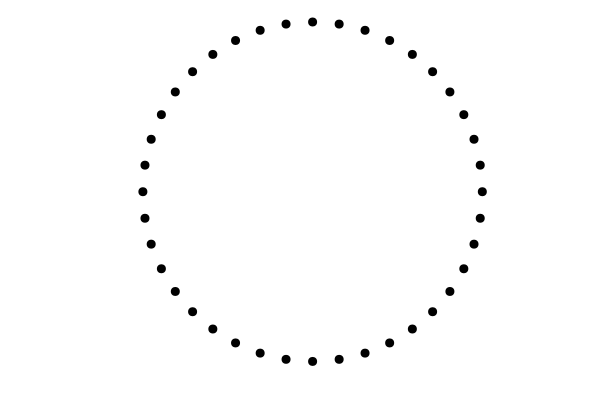

In [ ]:
using Random, Plots

function generate_noisy_circle(n::Int; noise_strength::Float64 = 0.25)
    angles = range(0, 2π, length=n+1)[1:end-1]  
    radii = 3 .+ noise_strength .* randn(n)
    xs = radii .* cos.(angles)
    ys = radii .* sin.(angles)
    return [(round(xs[i], digits=5), round(ys[i], digits=5)) for i in 1:n]
end


circ_pts = generate_noisy_circle(40, noise_strength=0.0)

# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)


In [15]:
function pt_dist(p1,p2)
    return sqrt((p1[1]-p2[1])^2 + (p1[2]-p2[2])^2)
end

pt_dist (generic function with 1 method)

In [11]:
F = Dict{}()

for i=1:length(circ_pts)
    for j=1:length(circ_pts)
        F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
    end
end

F

Dict{Any, Any} with 10000 entries:
  (41, 10) => 5.01788
  (17, 12) => 1.22658
  (19, 86) => 5.85607
  (65, 69) => 0.678131
  (97, 68) => 5.23968
  (55, 35) => 3.54436
  (9, 80)  => 4.85441
  (16, 99) => 3.02278
  (31, 14) => 3.03217
  (19, 16) => 0.579047
  (26, 53) => 5.16691
  (22, 9)  => 2.46476
  (30, 68) => 6.26238
  (36, 73) => 4.47719
  (42, 42) => 0.0
  (48, 61) => 2.717
  (27, 26) => 0.797353
  (40, 28) => 1.89574
  (66, 27) => 5.48449
  ⋮        => ⋮

In [25]:
pers_h1(F)

12-element Vector{NamedTuple}:
 (birth = 0.40498697781533677, death = 0.4265977557371816, cycle = [(26, 29), (27, 26), (30, 27), (30, 29)])
 (birth = 0.7158542355116718, death = 0.7440437313088525, cycle = [(9, 46), (59, 9), (55, 59), (55, 46)])
 (birth = 0.43530027750967487, death = 0.46801534675691997, cycle = [(5, 9), (5, 10), (11, 9), (11, 10)])
 (birth = 0.3712021594764772, death = 0.4148677086734999, cycle = [(30, 27), (28, 27), (30, 32), (32, 28)])
 (birth = 0.387732763898023, death = 0.4408167909687652, cycle = [(60, 2), (58, 59), (59, 2), (60, 58)])
 (birth = 0.546356745176629, death = 0.6093636886129663, cycle = [(44, 40), (44, 47), (46, 40), (46, 47)])
 (birth = 0.38161757952169867, death = 0.4522784523940976, cycle = [(30, 31), (34, 31), (30, 32), (32, 33), (34, 33)])
 (birth = 0.41745735327096595, death = 0.4916972935658687, cycle = [(16, 19), (20, 19), (16, 17), (20, 17)])
 (birth = 0.42569727483271497, death = 0.5055122684960277, cycle = [(20, 21), (20, 19), (23, 24), (2

In [26]:
x=persistenceHomology(F)

Dict{Any, Any} with 5 entries:
  Set(Any[[22, 19], [5, 59], [5, 10], [46, 40], [10, 14… => [0.495504, 0.546763]
  Set(Any[[8, 7], [8, 10], [2, 4], [5, 10], [1, 5], [7,… => [0.427159, 0.430265]
  Set(Any[[51, 55], [47, 44], [42, 41], [59, 2], [23, 1… => [0.377453, 0.726946]
  Set(Any[[22, 19], [17, 20], [19, 16], [24, 22], [24, … => [0.427159, 0.461331]
  Set(Any[[34, 33], [31, 30], [30, 32], [33, 32], [31, … => [0.382113, 0.389879]

In [22]:
function completeGraph(n)
    v=[]
    e=[]
    for i = 1:n
        push!(v,i)
    end

    for w1 in v
        for w2 in v
            push!(e,(w1,w2))
        end
    end

    return graph(v,e)
end

completeGraph (generic function with 1 method)

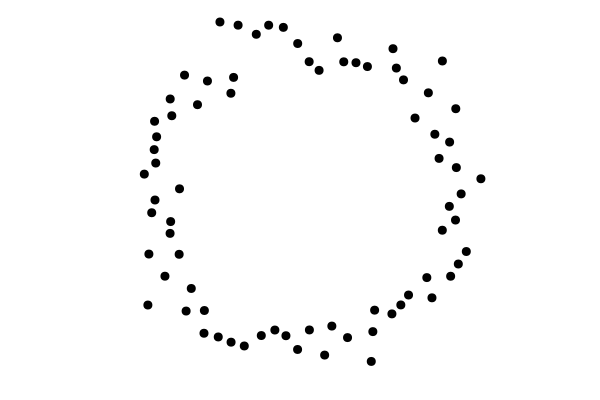

In [ ]:
using Random, Plots

function generate_noisy_circle(n::Int; noise_strength::Float64 = 0.25)
    angles = range(0, 2π, length=n+1)[1:end-1]  
    radii = 3 .+ noise_strength .* randn(n)
    xs = radii .* cos.(angles)
    ys = radii .* sin.(angles)
    return [(round(xs[i], digits=5), round(ys[i], digits=5)) for i in 1:n]
end


circ_pts = generate_noisy_circle(75, noise_strength=0.35)

# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)



In [35]:
F = Dict{}()

for i=1:length(circ_pts)
    for j=1:length(circ_pts)
        F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
    end
end

x=pers_h1(F)
y=persistenceHomology(F)

normal = []
for g in x 
    push!(normal,(g.birth,g.death))
end
cubical = []
for g in values(y)
    push!(cubical,(g[1],g[2]))
end

In [17]:
normal=[]
cubical=[]

Any[]

In [ ]:
tries=0
while length(normal)-length(cubical)<5 || tries > 1000

    circ_pts = generate_noisy_circle(45, noise_strength=0.3)

    F = Dict{}()

    for i=1:length(circ_pts)
        for j=1:length(circ_pts)
            F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
        end
    end

    x=pers_h1(F)
    y=persistenceHomology(F)

    normal = []
    for g in x 
        push!(normal,(g.birth,g.death))
    end
    cubical = []
    for g in values(y)
        push!(cubical,(g[1],g[2]))
    end

    tries+=1
end

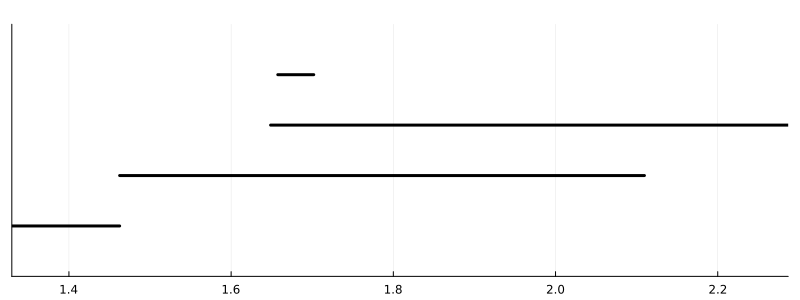

In [18]:
using Plots

function plot_barcode(bars, title_str::String)
    sorted_bars = sort(bars, by=x -> x[1])  # sort by birth time
    n = length(sorted_bars)
    ys = collect(1:n)
    births = [b[1] for b in sorted_bars]
    deaths = [b[2] for b in sorted_bars]

    plot(
        xlims = (minimum(births), maximum(deaths)),
        ylims = (0, n + 1),
        legend = false,
        yticks = false,
        title = title_str,
        size = (800, 300),
    )

    for i in 1:n
        plot!([births[i], deaths[i]], [ys[i], ys[i]], lw=3, color=:black)
    end

    return current()
end


plot_barcode(cubical, " ")


In [ ]:
plot_barcode(normal, " ")

In [ ]:
# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)

In [49]:

    circ_pts = generate_noisy_circle(80, 0.35)

    F = Dict{}()

    for i=1:length(circ_pts)
        for j=1:length(circ_pts)
            F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
        end
    end

    x=pers_h1(F)
    y=persistenceHomology(F)

    normal = []
    for g in x 
        push!(normal,(g.birth,g.death))
    end
    cubical = []
    for g in values(y)
        push!(cubical,(g[1],g[2]))
    end




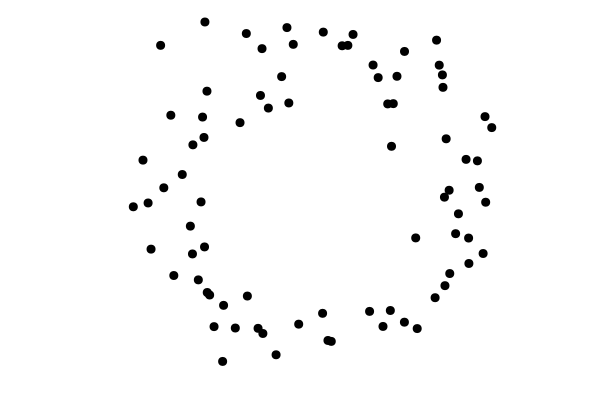

In [50]:
# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)

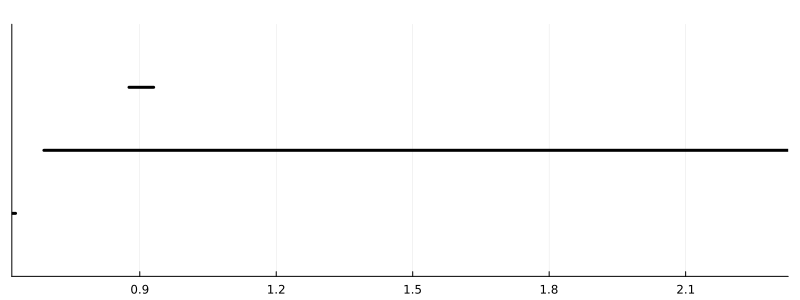

In [51]:
plot_barcode(cubical, " ")

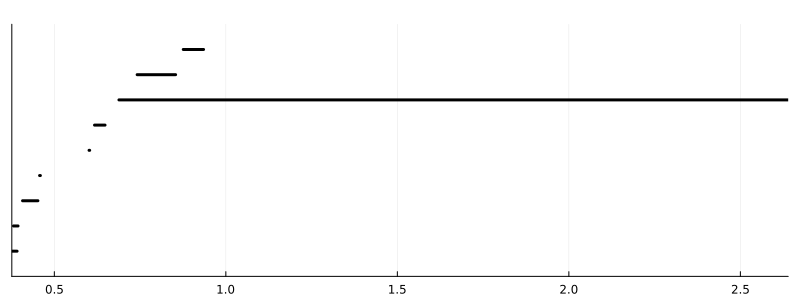

In [52]:
plot_barcode(normal, " ")

In [96]:

    circ_pts = generate_noisy_circle(100, 0.25)

    F = Dict{}()

    for i=1:length(circ_pts)
        for j=1:length(circ_pts)
            F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
        end
    end

    x=pers_h1(F)
    y=persistenceHomology(F)

    normal = []
    for g in x 
        push!(normal,(g.birth,g.death))
    end
    cubical = []
    for g in values(y)
        push!(cubical,(g[1],g[2]))
    end




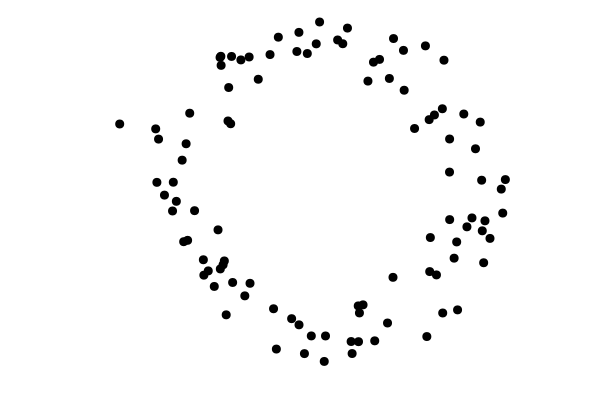

In [97]:
# Plot the points
xs = [p[1] for p in circ_pts]
ys = [p[2] for p in circ_pts]

scatter(xs, ys,
    markersize = 5,
    color = :black,
    legend = false,
    axis = false,
    framestyle = :none,
    aspect_ratio = :equal,
)

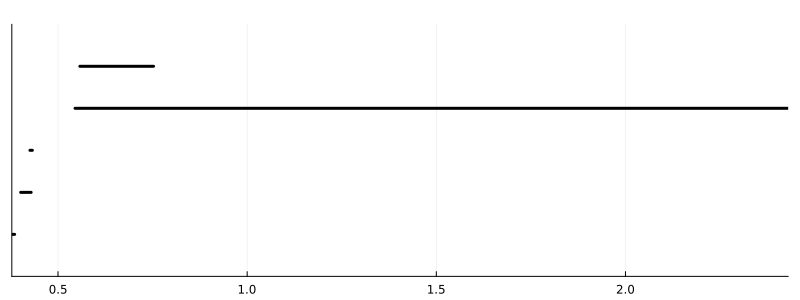

In [98]:
plot_barcode(cubical, " ")

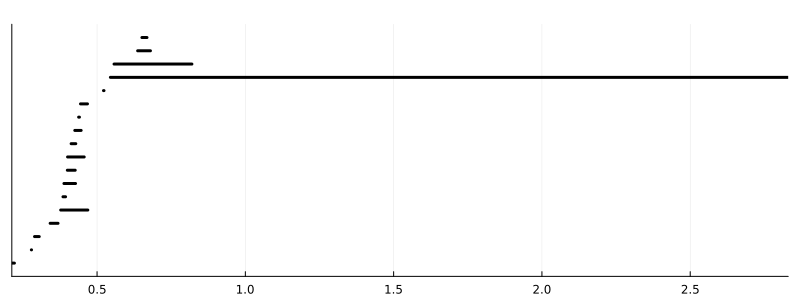

In [99]:

plot_barcode(normal, " ")

In [10]:
# returns all (necessary) cubes in a filtration and 
function get_time(F,c)
    return maximum([F[(c[1],c[2])],F[(c[1],c[3])],F[(c[2],c[4])],F[(c[3],c[4])]])
end

function ordered_cubes(F)
    V = []
    for x in keys(F)
        push!(V,x[1])
        push!(V,x[2])
    end
    V = unique!(V)


    B = Channel{}(length(collect(keys(F)))^2 + length(collect(keys(F))))

    @threads for i = 1:length(V)
        v = V[i]

        geq_v = V[i+1:end]

        #Handling for all distinct vertices
        for j = i+1:length(V)
            w=V[j]
            put!(B,(Set([v,w]), F[(v,w)]))
            geq_w = V[j+1:end]
            for v2 in geq_w
                for w2 in geq_v
                    
                    vec = [v,w,v2,w2]
                    t = get_time(F,vec)
                    put!(B,(vec,t))
                    vec = [v,v2,w,w2]
                    t = get_time(F,vec)
                    put!(B,(vec,t))
                end
                
                # if w2 = v 
                vec = [v,w,v2,v]
                t = get_time(F,vec)
                put!(B,(vec,t))

                vec = [v,v2,w,v]
                t = get_time(F,vec)
                put!(B,(vec,t))

            end

            # if v2 = v 
            for w2 in geq_w

                vec = [v,w,v,w2]
                t = get_time(F,vec)
                put!(B,(vec,t))

                vec = [v,v,w,w2]
                t = get_time(F,vec)
                put!(B,(vec,t))
    

            end
            
            for w2 in filter!(x -> x != w, geq_v)
                vec = [w,w2,v,w]
                t = get_time(F,vec)
                put!(B,(vec,t))
                vec = [w,v,w2,w]
                t = get_time(F,vec)
                put!(B,(vec,t))
            end

            vec = [v,v,w,v]
            t = get_time(F,vec)
            put!(B,(vec,t))

            vec = [w,w,v,w]
            t = get_time(F,vec)
            put!(B,(vec,t))

            

        end
    end

    close(B)

    B = collect(B)

    sorted_pairs = sort(B, by = x -> (x[2], length(x[1])))

    
    return getindex.(sorted_pairs, 1), sorted_pairs
end


    

ordered_cubes (generic function with 1 method)

In [11]:
function setup_matrix(F)

    C, sorted_pairs = ordered_cubes(F)
    V = []
    for x in keys(F)
        push!(V,x[1])
    end
    V = unique!(V)

    lv = length(V)

    n = lv + length(C)

    cols = [zeros(ZZ2,n) for v in V]

    for c in C
        if c isa AbstractSet

            v = zeros(ZZ2,n)

            for x in c 
                i = findfirst(y->y==x, V)
                v[i] += ZZ2(1)
            end

            push!(cols,v)
        else

            v = zeros(ZZ2,n)

            bd = [Set([c[1],c[2]]),Set([c[1],c[3]]),Set([c[4],c[2]]),Set([c[4],c[3]])]

            for x in bd 
                if length(x) == 2
                    
                    i = findfirst(y->y==x,C) 
                    v[i + lv] += ZZ2(1)
                end
            end

            push!(cols,v)
        end
    end

    return hcat(cols ...), vcat([(v,0) for v in V],sorted_pairs)
end




setup_matrix (generic function with 1 method)

In [12]:
function persistence_pairs(B)
    R = copy(B)
    n = size(R, 2)
    low = Dict{Int, Int}()

    for j in 1:n
        while true
            # Instead of findall, use a loop:
            i = 0
            for k in size(R, 1):-1:1
                if !iszero(R[k, j])
                    i = k
                    break
                end
            end

            if i == 0
                break
            end

            if haskey(low, i)
                R[:, j] .= R[:, j] + R[:, low[i]]
            else
                low[i] = j
                break
            end
        end
    end

    return collect(low)
end

persistence_pairs (generic function with 1 method)

In [49]:
M,t=setup_matrix(F)

(ZZ2[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], Any[(11, 0), (16, 0), (18, 0), (17, 0), (8, 0), (19, 0), (7, 0), (14, 0), (1, 0), (2, 0)  …  ([7, 6, 16, 7], 4.856634238070641), ([7, 16, 6, 7], 4.856634238070641), ([7, 5, 16, 7], 4.856634238070641), ([7, 16, 5, 7], 4.856634238070641), ([7, 4, 16, 7], 4.856634238070641), ([7, 16, 4, 7], 4.856634238070641), ([7, 13, 16, 7], 4.856634238070641), ([7, 16, 13, 7], 4.856634238070641), ([16, 16, 7, 16], 4.856634238070641), ([7, 7, 16, 7], 4.856634238070641)])

In [57]:
using SparseArrays
function persistence_pairs!(B::AbstractMatrix)
    n = size(B, 2)
    pair = Dict{Int, Int}()

    for j in 1:n
        while true
            nz = findnz(B[:, j])[1]
            isempty(nz) && break
            i = maximum(nz)

            if haskey(pair, i)
                B[:, j] .= B[:, j] + B[:, pair[i]]
            else
                pair[i] = j
                break
            end
        end
    end

    return pair
end


persistence_pairs! (generic function with 1 method)

In [ ]:
persistence_pairs!(sparse(M))

In [48]:
x=persistence_pairs(M)


190-element Vector{Pair{Int64, Int64}}:
  1813 => 1814
  7613 => 7614
  4138 => 4139
   826 => 829
  1703 => 1708
  1616 => 1617
  6772 => 6773
   417 => 418
   479 => 798
  3324 => 3325
       ⋮
   286 => 287
   338 => 339
   613 => 614
     3 => 86
    96 => 97
  7303 => 7304
   181 => 182
 15400 => 15401
 20210 => 20211

In [13]:
function persistence(F)
    M, times = setup_matrix(F)

    pairs = persistence_pairs(M)

    gens = []

    for x in pairs
        b = times[x[1]][2]
        d = times[x[2]][2]
        if b != d 
            push!(gens, (times[x[1]][1],b,d))
        end
    end

    return gens 
end



persistence (generic function with 1 method)

In [44]:
circ_pts = generate_noisy_circle(20, 0.5)
F = Dict{}()

for i=1:length(circ_pts)
    for j=1:length(circ_pts)
        F[(i,j)] = pt_dist(circ_pts[i],circ_pts[j])
    end
end

In [45]:
persistenceHomology(F)

Dict{Any, Any} with 2 entries:
  Set(Any[[15, 18], [6, 9], [5, 6], [1, 3], [13, 9], [19,… => [1.60193, 1.80535]
  Set(Any[[6, 9], [5, 6], [13, 2], [13, 9], [2, 3], [5, 3… => [1.50022, 1.77992]

In [46]:
persistence(F)

21-element Vector{Any}:
 (Set([1, 19]), 1.5962492471102372, 1.7936381588826662)
 (15, 0, 0.4196023003988418)
 (8, 0, 1.2624876738408184)
 (7, 0, 1.2468657225218762)
 (3, 0, 0.789150393904736)
 (5, 0, 0.946759996197558)
 (4, 0, 0.7203234891352635)
 (12, 0, 0.8348731274271559)
 (6, 0, 0.8391469442237156)
 (19, 0, 1.4925952279502974)
 ⋮
 (10, 0, 0.14427243153146063)
 (16, 0, 1.3133086876283124)
 (2, 0, 0.6898511516262041)
 (13, 0, 1.2010049558598832)
 (1, 0, 1.0450729850589384)
 (14, 0, 0.3166619025080223)
 (9, 0, 1.0173707141941917)
 (Set([13, 2]), 1.4776684104696831, 1.7633065213115955)
 (18, 0, 0.9610548443247138)